<a href="https://colab.research.google.com/github/sudipta-on/Quantum-Many-Body-Problem-using-Netket/blob/main/Bosonic_Harmonic_Trap_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $$\textbf{Ground-State: Bosons in a 3D Harmonic trap}$$

$\qquad \qquad \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad \text{ - Sudipta Majumder}$

$2 $ $\text{July},2024$

## Problem Overview
We will explore the capabilities of NetKet to study the ground-state of bosonic many-body quantum systems in continuous space. As a first step we will consider an easy problem of non-interacting harmonic oscillators in free, three dimensional space, to introduce and explain the moving parts needed to perform a VMC optimization. Subsequently a more challenging example of interacting bosons in one dimensions with periodic boundary conditions will be studied.

Specifically, we will study the following two Hamiltonians:

$$
\mathcal{H}= -\frac{\hbar^2}{2m}\sum_i \nabla_{\mathbf{x}_i}^2 + \frac{1}{2} m \omega^2 \sum_i |\mathbf{x}_i|^2
$$

and

$$
\mathcal{H}= -\frac{\hbar^2}{2m}\sum_i \nabla_{\mathbf{x}_i}^2 + \epsilon \sum_{i<j} \exp\left[-\frac{1}{2}|\mathbf{r}_{ij}|^2\right]
$$

,where the first term represents the kinetic energy contribution of particles of mass $m$, and the second term is the potential (interaction) energy ( $ \mathbf{r}_{ij} = \mathbf{x}_i-\mathbf{x}_j $ ). In the following we set $m = \omega = \hbar = \frac{\epsilon}{2} =1$.

In [ ]:
!pip install netket --quiet

In [ ]:
#Checking verions
import platform
import netket as nk

print("Python version", platform.python_version())
print("NetKet version", nk.__version__)

Python version 3.10.12
NetKet version 3.13.0


## 1. Defining The Hilbert Space and Sampler

The first ingredient in defining our problem in NetKet, consists of defining the Hilbert Space to study.
For continuous space systems, the Hilbert space takes information about the number of particles, the size of the system and the type of boundary conditions: open or periodic. The dimensionality of space is inferred from the size of the system.
The species of particles (bosonic or fermionic) is not relevant for the Hilbert space but only in defining the variational Ansatz (symmetric or antisymmetric).
In the following the Hilbert space for $N=10$ particles in open (infinite) space is defined.

In [ ]:
import jax.numpy as jnp
N = 10

# 10 particles in 3D space without periodic boundary conditions.
# The length of the L-tuple indicates the spatial dimension of space.
hi = nk.hilbert.Particle(N=N, L=(jnp.inf, jnp.inf, jnp.inf), pbc=False)

# One can also use the shorter notation to build this kind of setups
hi = nk.hilbert.Particle(N=N, D=3)

We can now generate random configurations in the Hilbert space, we just defined. For the above specifications the random state will consists of a vector of $N*d = 10*3$ numbers ($d$ number of spatial dimensions), representing the 10 3D positions of the particles under consideration.

In [ ]:
import jax
states = hi.random_state(jax.random.key(0), 1)  # 1 configuration

# One can always reshape those configurations to NxD matrix
states.reshape(N, 3)

Array([[-0.28371066,  0.9368162 , -1.0050073 ],
       [ 1.4165013 ,  1.0543301 ,  0.9108127 ],
       [-0.42656708,  0.986188  , -0.5575324 ],
       [ 0.01532502, -2.078568  ,  0.5548371 ],
       [ 0.91423655,  0.5744596 ,  0.7227863 ],
       [ 0.12106175, -0.3237354 ,  1.6234998 ],
       [ 0.24500391, -1.3809781 , -0.6111237 ],
       [ 0.1403725 ,  0.84100425, -1.0943578 ],
       [-1.077502  , -1.1396457 , -0.593338  ],
       [-0.15576515, -0.38321444, -1.1144515 ]], dtype=float32)

Now we want to be able to sample from a probability distribution, defined in the Hilbert space. To do this, NetKet provides the so-called Metropolis-Hasting sampler. This sampler uses an initial state in the Hilbert space (e.g. a random state) and produces a new state according to a transtition rule. The new state is accepted (e.g. becomes the initial state for another update according to the transition rule) if its probability is high enough (the probability of the state is determined by the variational Ansatz, see later). While you can write your own transition rule, NetKet already implements a common transition rule, that often is sufficient to run a VMC optimization.
The transition rule is given by adding normally distributed noise to the initial state:

$$
\mathbf{X} = (\mathbf{x}_1,...,\mathbf{x}_N) \mapsto \mathbf{X} + \mathbf{\Delta} = (\mathbf{x}_1 + \mathbf{\delta}_1,...,\mathbf{x}_N +\mathbf{\delta}_N),
$$

where $ \mathbf{\delta}_i \sim \mathcal{N}(0,\sigma^2) $ and $ \sigma $ is chosen by the user, dependent on the system under consideration.
To decorrelate samples, the sampler provides functionality to insert more substeps of the above rule (e.g. add Gaussian noise multiple times). You can also specify how many parallel chains of the above rule you want to run. In the following, we initialize the sampler, with $ \sigma=0.1 $, 16 parallel chains, with 32 substeps of the transition rule.

In [ ]:
sa = nk.sampler.MetropolisGaussian(hi, sigma=0.1, n_chains=16, sweep_size=32) # Metropolis-Hasting Sampler

## 2. Defining The Hamiltonian

As written above we will start with a simple example of non-interacting particles, confined by a harmonic potential e.g. a collection of harmonic oscillators.
A Hamiltonian in continuous space usually consists of two parts: kinetic and potential energy.
The form of the kinetic energy is always the same and only depends on the mass of the particles.
NetKet provides a full implementation of the the kinetic energy, which is simply the trace of the (weighted) Hessian taken with respect to all the input variables of the variational state.

$$
    E_{kin} = \sum_{i=1}^N \frac{1}{2m_i}\frac{\partial}{\partial \mathbf{x}_i} \cdot \frac{\partial}{\partial \mathbf{x}_i} = \sum_{i=1}^N \sum_{j=1}^D \frac{1}{2m_i}\frac{\partial^2}{\partial x_{ij}^2}
$$

In the following we initialize the kinetic energy operator for particles of masses $ m=1 $ (one could also provide a tuple of different masses for each particle).


In [ ]:
# Kinetic Energy
ekin = nk.operator.KineticEnergy(hi, mass=1.0)

The potential energy part changes when changing from one system to another and therefore needs to be implemented from scratch. In NetKet this amounts to writing a function that takes a single sample $ \mathbf{X} $ and outputs a single number representing the potential energy of the given configuration. For a harmonic confinement we have:

$$
\mathbf{X} \mapsto \frac{1}{2}\sum_i |\mathbf{x}_i|^2
$$

or in code:

In [ ]:
# Potential Energy
def v(x):
    return 0.5 * jnp.linalg.norm(x) ** 2

pot = nk.operator.PotentialEnergy(hi, v)

In [ ]:
#Total hamiltonain
H = ekin + pot

## 3. Exact Ansatz

The most important thing for every VMC simulation is the variational Ansatz to the problem. If the Ansatz is capable of representing the true ground-state, the VMC results will be significantly better compared to a poorly chosen Ansatz that cannot represent the ground-state.
For the case of non-interacting harmonic oscillators we know exactly what the many-body ground-state looks like:

$$
\psi(\mathbf{X}) = \prod_i \exp\left[-\frac{1}{2} |\mathbf{x}_i|^2\right].
$$

with associated probability distribution $P(\mathbf{X}) = \prod_i \exp\left[-|\mathbf{x}_i|^2\right]$.
To provide some first experience with NetKet in continuous space, we first choose a variational parameterization that can exactly represent the above state:

$$
\psi(\mathbf{X}) = \exp\left[-\frac{1}{2} \mathbf{X}^T\Sigma^{-1}\mathbf{X}\right].
$$

which is the ground-state for $ \Sigma^{-1} = \mathbb{I} $.

The Model can be defined using one of the several *functional* jax frameworks such as Jax/Stax, Flax or Haiku.

NetKet includes several pre-built models and layers built with [Flax](https://github.com/google/flax), including the above multivariate Gaussian Ansatz. For completeness the model definition is copied below (to make sure that $ \Sigma^{-1} $ is a proper covariance matrix (positive definite), we parameterize it as $ \Sigma^{-1} = T T^T $):

In [ ]:
import flax.linen as nn
import jax.numpy as jnp

from flax.linen.dtypes import promote_dtype
from flax.linen.initializers import normal

from netket.utils.types import DType, Array, NNInitFunc

class Gaussian(nn.Module):
    r"""
    Multivariate Gaussian function with mean 0 and parametrised covariance matrix
    :math:`\Sigma_{ij}`.

    The wavefunction is given by the formula: :math:`\Psi(x) = \exp(\sum_{ij} x_i \Sigma_{ij} x_j)`.
    The (positive definite) :math:`\Sigma_{ij} = AA^T` matrix is stored as
    non-positive definite matrix A.
    """

    param_dtype: DType = jnp.float64
    """The dtype of the weights."""
    kernel_init: NNInitFunc = normal(stddev=1.0)
    """Initializer for the weights."""

    @nn.compact
    def __call__(self, x_in: Array):
        nv = x_in.shape[-1]

        kernel = self.param("kernel", self.kernel_init, (nv, nv), self.param_dtype)
        kernel = jnp.dot(kernel.T, kernel)

        kernel, x_in = promote_dtype(kernel, x_in, dtype=None)
        y = -0.5 * jnp.einsum("...i,ij,...j", x_in, kernel, x_in)

        return y

The model above gives instructions on how to initialize the variational parameters and evaluate the model. To use it in the context of the VMC optimization, NetKet provides the Monte-Carlo-sampled Variational State `netket.vqs.MCState`, which requires a sampler and a model from which to sample from. We also have to provide the number of samples from which expectation values of operators are computed, at each iteration of the VMC optimization.
In the following we construct the variational state from the multivariate Gaussian Ansatz above, using the Gaussian sampler to sample from it and we choose a total of 10000 samples per iteration.

In [ ]:
Gauss = Gaussian()
vstate = nk.vqs.MCState(sa, Gauss, n_samples=10**4, n_discard_per_chain=100)

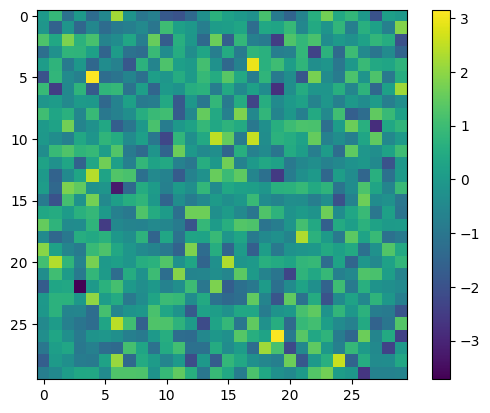

In [ ]:
import matplotlib.pyplot as plt

# now we can inspect the parameters which form a N*dxN*d matrix
plt.imshow(vstate.parameters['kernel'])
plt.colorbar()
plt.show()

In [ ]:
# Expectation value
E = vstate.expect(H)
print(E)

224.2 ± 1.6 [σ²=5905.9, R̂=1.0134]


In [ ]:
print("Mean                  :", E.mean)
print("Error                 :", E.error_of_mean)
print("Variance              :", E.variance)
print("Convergence indicator :", E.R_hat)
print("Correlation time      :", E.tau_corr)

Mean                  : 224.21750593402638
Error                 : 1.6314022647815551
Variance              : 5905.880673277661
Convergence indicator : 1.0134195556573782
Correlation time      : 1.7532400303791746


## 4. Variational Monte Carlo

We will now try to optimise the covariance matrix $ \Sigma^{-1} $ in order to best approximate the ground state of the hamiltonian, which has a ground-state energy of $ \frac{1}{2}N*d=15 $.

At first, we'll try to do this by ourself by writing the training loop, but then we'll switch to using a pre-made
solution provided by netket for simplicity.


### A. DIY Optimisation Loop

The optimisation (or training) loop must do a very simple thing: at every iteration it must compute the energy and it's gradient, then multiply the gradient by a certain learning rate $\lambda = 0.05$ and lastly it must update the parameters with this rescaled gradient.

One can do so as follows:

In [ ]:
from tqdm import tqdm  # tqdm helps us to visualize the progress in form of progress bar)

energy_history = []
n_steps = 100

for i in tqdm(range(n_steps)):
    # compute the energy and the gradient
    E, E_grad = vstate.expect_and_grad(H)
    energy_history.append(E.mean.real)
    new_params = jax.tree.map(lambda x,y: x - 0.05 * y, vstate.parameters, E_grad)
    vstate.parameters = new_params

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


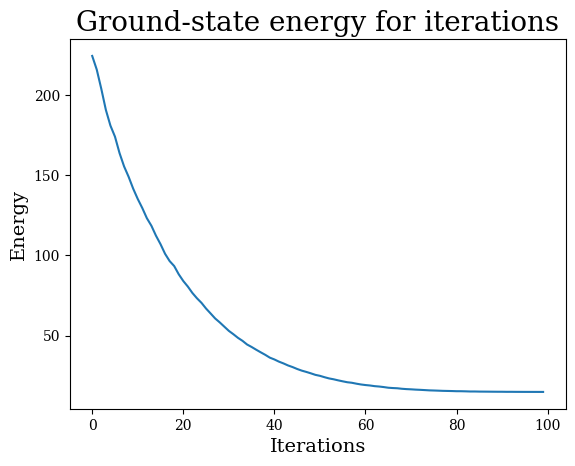

In [ ]:
# We now can plot the energy during those optimisation steps:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.rc('font', family = 'Serif', size = 14)
matplotlib.rc('xtick', labelsize = 10)
matplotlib.rc('ytick', labelsize = 10)

plt.plot(energy_history)
plt.title("Ground-state energy for iterations", fontsize = 20)
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.show()

### B. Use NetKet's optimisation driver

The optimisation (or training) loop must do a very simple thing: at every iteration it must compute the energy and it’s gradient, then multiply the gradient by a certain learning rate and lastly it must update the parameters with this rescaled gradient.

We use NetKet's default VMC optimisation loop for that

In [ ]:
# First reset the parameters to run the optimisation again
vstate.init_parameters(normal(stddev=1.0))
# defining new optimizer
optimizer = nk.optimizer.Sgd(learning_rate=0.05)
# build the optimisation driver
gs = nk.driver.VMC(H, optimizer, variational_state=vstate)

log = nk.logging.RuntimeLog()
gs.run(n_iter=200, out=log)

energy=vstate.expect(H)
error = jnp.abs(energy.mean-15.)/15.
print(f"Optimized energy  : {energy.mean}")
print(f"Relative error    : {error}")

  0%|          | 0/200 [00:00<?, ?it/s]

Optimized energy  : 15.000000275120751
Relative error    : 1.834138340465567e-08


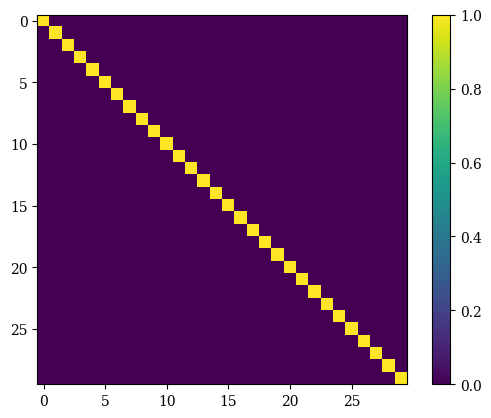

In [ ]:
# we can again inspect the parameter:
kernel = vstate.parameters['kernel']
plt.imshow(jnp.dot(kernel.T, kernel))
plt.colorbar()
plt.show()

## 5. Neural-Network Quantum State

But everytimes we can not define or know the functional form of the ground state wave-function. We therefore have to resort to highly flexible variational Ansatze, capable of representing many different many-body states. We can for example use neural networks as universal function approximators.

In the following, we use a neural network architecture called "DeepSets" to solve the more interesting case of bosons interacting via a repulsive Gaussian interaction:

$$
\epsilon  \sum_{i<j} \exp\left[-|\mathbf{r}_{ij}|^2\right].
$$

We study the bulk of the system by confining it into a box of length $L$ with periodic boundary conditions. In this extended system we define the particle density as $ D = N/L^d $ and we study the case $ D=1 $ for $ N=20 $ particles in $ d=1 $ dimensions with $ \epsilon = 2 $. To account for the periodicity we use the minimum image convention when evaluating the potential energy of the system. For more information see:

The DeepSets architecture we use is defined as:

$$
\mathrm{DS}(\mathbf{X}) = \rho\left[\sum_{i,j} \phi \left( \mathbf{y}_{ij}\right) \right]
$$

where the functions $ \phi $ and $ \rho $ are parameterized by simple feed-forward neural network with a GeLu activation function with one hidden layer.  
To account for periodicity we choose as input $ \mathbf{y}_{ij} = (\sin(\frac{2\pi}{L} \mathbf{r}_{ij}),  \cos(\frac{2\pi}{L} \mathbf{r}_{ij})) $.

In [ ]:
def minimum_distance(x, N, sdim):
   """Computes distances between particles using minimum image convention"""
   x = x.reshape(-1, N, sdim)
   idx = jnp.triu_indices(N, 1)
   distances = (-x[..., None, :, :] + x[..., :, None, :])[..., idx[0], idx[1], :]
   # minimum image convention
   distances = jnp.remainder(distances + L / 2.0, L) - L / 2.0
   return jnp.linalg.norm(distances, axis=-1)

def potential(x, N, epsilon, sdim):
   dis = minimum_distance(x, N, sdim)
   return epsilon * jnp.sum((jnp.exp(-(dis)**2)))

# parameters
N = 20 # No. of particles
D = 1. # Density of particles
dim = 1 # Dimension of space
epsilon = 2. # Potential energy parameter
L = (N / D)**(1/dim) # Box length


hilb = nk.hilbert.Particle(N=N, L=(L,), pbc=True) # Hilbert space for extended system
sa = nk.sampler.MetropolisGaussian(hilbert=hilb, sigma=0.4, n_chains=16, sweep_size=10) # Metropolis-Hasting Sampler


ekin = nk.operator.KineticEnergy(hilb, mass=1.0)  # Kinetic Energy
pot = nk.operator.PotentialEnergy(hilb, lambda x: potential(x, N, epsilon, dim)) # Potential Energy
Ha = ekin + pot # Total Hamiltonian

In [ ]:
class DS(nn.Module):
    L: float
    N: int
    sdim: int
    hidden_units : int = 8

    @nn.compact
    def __call__(self, x):
        x = x.reshape(-1, self.N, self.sdim)
        xij = x[...,None,:] - x[...,None,:,:]
        yij = jnp.concatenate((jnp.sin(2*jnp.pi/self.L * xij), jnp.cos(2*jnp.pi/self.L * xij)), axis=-1)

        # we construct the first dense layer using a pre-built implementation in flax.
        y = nn.Dense(features=self.hidden_units)(yij)
        # we apply the activation function
        y = nn.gelu(y)
        # we apply the dense layer to the input
        y = nn.Dense(features=self.hidden_units)(y)
        y = jnp.sum(y, axis=(-3,-2))

        # the function rho has a single output
        y = nn.Dense(features=self.hidden_units)(y)
        y = nn.gelu(y)
        y = nn.Dense(features=1)(y)
        return y.squeeze()

model = DS(L=L, N=N, sdim=dim)

# choose number of samples that is divided by the number of chains
vstate = nk.vqs.MCState(sa, model, n_samples=1008, n_discard_per_chain=16)

In [ ]:
# defining optimizer
optimizer = nk.optimizer.Sgd(learning_rate=0.02)
# build the optimisation driver
gs = nk.driver.VMC(Ha, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.05))

# Store the energy along the simulation in a RuntimeLogger, which is kept in memory.
log=nk.logging.RuntimeLog()
gs.run(n_iter=200,out=log)

ds_energy=vstate.expect(Ha)
error=abs((ds_energy.mean-24.742)/24.742)
print(f"Optimized energy  : {ds_energy.mean}")
print(f"Relative error    : {error}")

  0%|          | 0/200 [00:00<?, ?it/s]

Optimized energy  : 24.758399110260992
Relative error    : 0.0006628045534310597


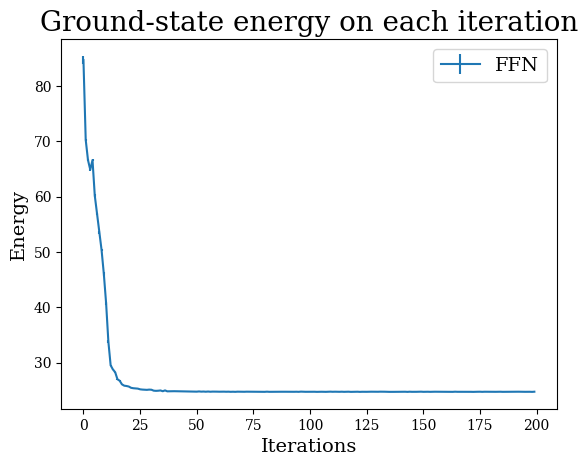

In [ ]:
data_FFN = log.data

plt.errorbar(data_FFN["Energy"].iters, data_FFN["Energy"].Mean, yerr=data_FFN["Energy"].Sigma, label="FFN")
plt.legend()
plt.title("Ground-state energy on each iteration", fontsize = 20)
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.show()

## 6. Measuring Other Properties

Once the model has been optimized, we can of start to measure other observables than the energy as well. An interesting quantity could for example be the radial distribution function, which is related to the structure factor measured in scattering experiments. It is defined as:

$$
g(r) = C \langle \sum_{i<j} \delta(r-r_{ij}) \rangle
$$

where $ \langle \cdot \rangle $ denotes the expectation value w.r.t. the probability distribution defined by the optimized wave-function. The constant $C$ is chosen such that $\int \mathrm{d}r g(r) = N*(N-1)$.

To evaluate the above expression we need samples from the optimized wave-function:

In [ ]:
samples = vstate.sample(chain_length=3*10**4)

import numpy as np
import jax

def gr(samples, n_particles, sdim, L, bins=80):
    dists = minimum_distance(samples, n_particles, sdim)
    hist, bin_edges = np.histogram(dists.flatten(), bins=bins, range=(0,L/2))
    delta_r = bin_edges[1] - bin_edges[0]
    centers = (bin_edges[1:] + bin_edges[:-1])/2

    gC = hist / (dists.shape[0]*n_particles)

    def get_jacobian():
        if sdim == 1:
            return np.ones_like(centers)
        elif sdim == 2:
            return 2*np.pi*centers
        elif sdim == 3:
            return 4*np.pi*centers**2
        else:
            raise NotImplementedError(f"Jacobian factor not yet implemented for sdim={sdim}")

    def get_volume():
        return L**sdim

    def get_density():
        return n_particles/get_volume()

    gU = get_jacobian()*delta_r*get_density()

    return centers, gC/gU

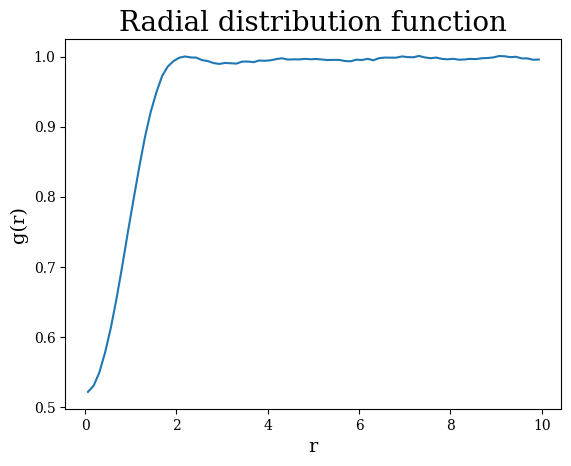

In [ ]:
c, g = gr(samples, n_particles=N, sdim=dim, L=L)
plt.plot(c, g)
plt.title("Radial distribution function", fontsize = 20)
plt.xlabel('r')
plt.ylabel('g(r)')
plt.show()